### Code reads stock values from csv file
* Location of input files is set in get_filename
* Location of output file is set in separate cell
* Run Main method to get all values for ticker listed in it
* Values changes are in  %
* ToDo: check if input file exists
* Modified functions to support two types of outputs: dataset1, dataset2; see comments below for details

In [46]:
# Dependencies
import csv
import os
import pandas as pd 
import matplotlib.pyplot as plt

In [47]:
# Supporting functions
def get_filename(ticker):
    return os.path.join("..", "InputData", ticker + ".csv") # use relative location of the input files to the notebook

In [48]:
def read_ticker_file(file_name):
    # Input file into dataframe
    rawdata = pd.read_csv(file_name) 
    # Date into date type, date of week, week of year, Close value
    rawdata.Date = rawdata.Date.astype('datetime64[ns]')
    rawdata['Year.Week'] = [ td.year + (int(td.strftime("%W"))) / 100 for td in rawdata.Date] # YYYY.0W
    rawdata['Weekday'] = [ td.weekday() for td in rawdata.Date]
    rawdata['CloseValue'] = rawdata.Close
    
    # Pivot data
    return rawdata.pivot(index='Year.Week', columns='Weekday', values='CloseValue')

def get_ticker_data(ticker):
    # Read data from input file, calculate changes between two days
    middata = read_ticker_file(get_filename(ticker))
    middata.columns = ['Mo', 'Tu', 'We', 'Th', 'Fr'] # change column names, pandas does not like numerical values (?)
    return middata

In [49]:
delta1 = 'Th..Mo'
delta2 = 'Mo..Th'

def get_dataset1(ticker):
    # This dataset has index, Ticker, and Th..Mo, Mo..Th delta values
    midset1 = get_ticker_data(ticker)
    midset1['Tmp'] = midset1.Th.shift(1) # move the column values one row down, it's used for cross week change calculation
    midset1[delta1] = 100 * (midset1.Mo - midset1.Tmp) / midset1.Tmp # relative change from last week Thurday to Monday
    midset1[delta2] = 100 * (midset1.Th - midset1.Mo) /  midset1.Mo # change from Monday to this week Thursday
    midset1 = midset1.drop('Tmp', axis=1) # drop temporaty column
    
    # Clean input data
    cleanset1 = midset1.dropna() # drop rows wiht n/a values; run this before columns reduction 
    cleanset1 = cleanset1.loc[:, [delta1, delta2]] # only needed columns
    cleanset1.insert(loc=0, column='Ticker', value=ticker)
    return cleanset1

In [50]:
def get_dataset2(ticker):
    # This dataset has index, Ticker, and Th..Mo, Mo..Th delta values
    midset2 = get_ticker_data(ticker)
    midset2['Tmp'] = midset2.Fr.shift(1) # move the column values one row down, it's used for cross week change calculation
    # Calculate relative value changes for each weekday
    midset2['Fr'] = 100 * (midset2.Fr - midset2.Th) /  midset2.Th
    midset2['Th'] = 100 * (midset2.Th - midset2.We) /  midset2.We
    midset2['We'] = 100 * (midset2.We - midset2.Tu) /  midset2.Tu
    midset2['Tu'] = 100 * (midset2.Tu - midset2.Mo) /  midset2.Mo
    midset2['Mo'] = 100 * (midset2.Mo - midset2.Tmp) / midset2.Tmp
    midset2 = midset2.drop('Tmp', axis=1) # drop temporaty column
    
    # Clean input data
    cleanset2 = midset2.dropna() # drop rows wiht n/a values; run this before columns reduction 
    cleanset2.insert(loc=0, column='Ticker', value=ticker)
    cleanset2.insert(loc=1, column='Year', value=cleanset2.index)
    cleanset2.Year = cleanset2.Year.astype(int) # get year number by column data type change
    return cleanset2

In [51]:
# Main method, call it to extract data from input file into DataFrame
def main(setnr):
    # List of tickers
    tickers = ["XLB","XLC","XLE","XLF","XLI","XLK","XLP","XLRE", "XLU", "XLV", "XLY"]

    outputdf = pd.DataFrame()

    print(f"Running data extraction {setnr} ...")
    print("Ticker: ", end = '')
    for ticker in tickers:
        if(setnr == 1):
            outputdf = outputdf.append(get_dataset1(ticker))
        elif(setnr == 2):
            outputdf = outputdf.append(get_dataset2(ticker))
        else:
            continue
        print(ticker, end = ' ')
    print("")
    print("... done.")

    return outputdf

In [52]:
# Run data extraction
# Returned value is df, you can save its value into file, or use it otherwise
dataout2 = main(2)
dataout2.head()

Running data extraction 2 ...
Ticker: XLB XLC XLE XLF XLI XLK XLP XLRE XLU XLV XLY 
... done.


,Ticker,Year,Mo,Tu,We,Th,Fr
Year.Week,,,,,,,
2000.02,XLB,2000,-0.341448,-1.199336,-1.445109,0.410580,-0.700935
2000.04,XLB,2000,-2.639897,-1.872151,0.000000,0.526316,-1.701571
2000.05,XLB,2000,-0.599227,1.808466,0.460552,-1.702735,-0.133193
2000.06,XLB,2000,-1.934648,-0.272109,-1.978198,-0.835073,-2.456114
2000.07,XLB,2000,1.654649,4.317084,-2.306649,-0.208360,-3.061935


In [53]:
# Check basic stat
dataout2.describe()

,Year,Mo,Tu,We,Th,Fr
count,7490.000000,7490.000000,7490.000000,7490.000000,7490.000000,7490.000000
mean,2009.498531,-0.012513,0.076074,0.018158,0.055368,-0.033339
std,5.717903,1.510480,1.417790,1.422972,1.457670,1.273787
min,2000.000000,-16.666670,-10.561794,-14.443789,-14.396521,-8.115132
25%,2005.000000,-0.601858,-0.584910,-0.610038,-0.579228,-0.613541
50%,2010.000000,0.032946,0.072316,0.061108,0.100594,0.011821
75%,2015.000000,0.645092,0.708001,0.692056,0.739479,0.619640
max,2019.000000,16.474647,15.705618,13.104257,11.748884,11.844084


In [54]:
# Data into output file
outfile = os.path.join("..", "OutputData", "TickersDataSet2.csv")
dataout2.to_csv(outfile)

In [55]:
# Get dataset1
dataout1 = main(1)
dataout1.head()

Running data extraction 1 ...
Ticker: XLB XLC XLE XLF XLI XLK XLP XLRE XLU XLV XLY 
... done.


,Ticker,Th..Mo,Mo..Th
Year.Week,,,
2000.02,XLB,-0.398158,-2.227320
2000.04,XLB,-2.209620,-1.355689
2000.05,XLB,-2.290601,0.535834
2000.06,XLB,-2.065265,-3.061251
2000.07,XLB,-0.842105,1.698514


In [56]:
# Check basic stat
dataout1.describe()

,Th..Mo,Mo..Th
count,7534.000000,7534.000000
mean,-0.032672,0.143921
std,1.963821,2.429792
min,-14.234365,-23.089889
25%,-0.882447,-1.025743
50%,0.087238,0.187795
75%,0.941647,1.347232
max,18.918925,30.031933


In [57]:
# Data into output file
outfile = os.path.join("..", "OutputData", "TickersDataSet1.csv")
dataout1.to_csv(outfile)

Text(0.5, 0.98, 'Stock value change (%) count from Monday to Thurday')

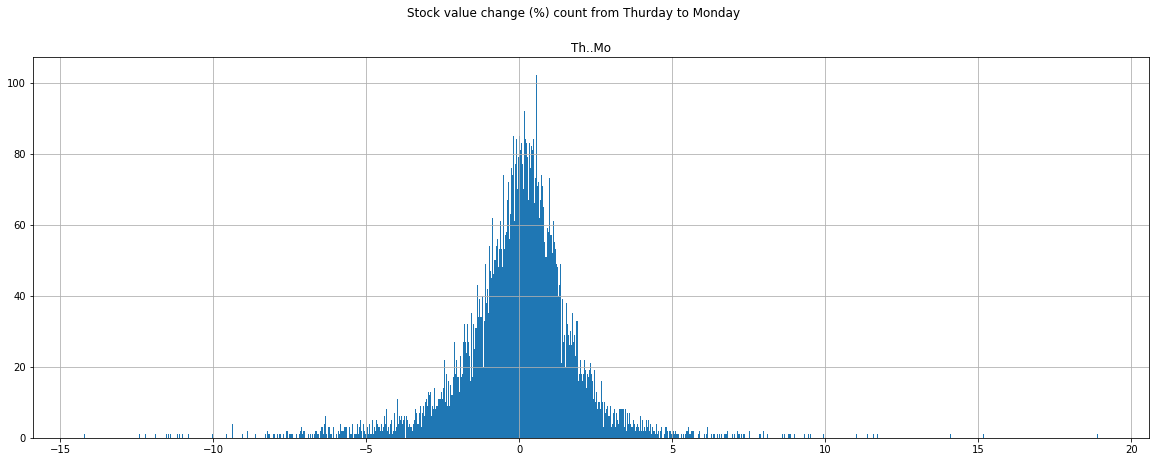

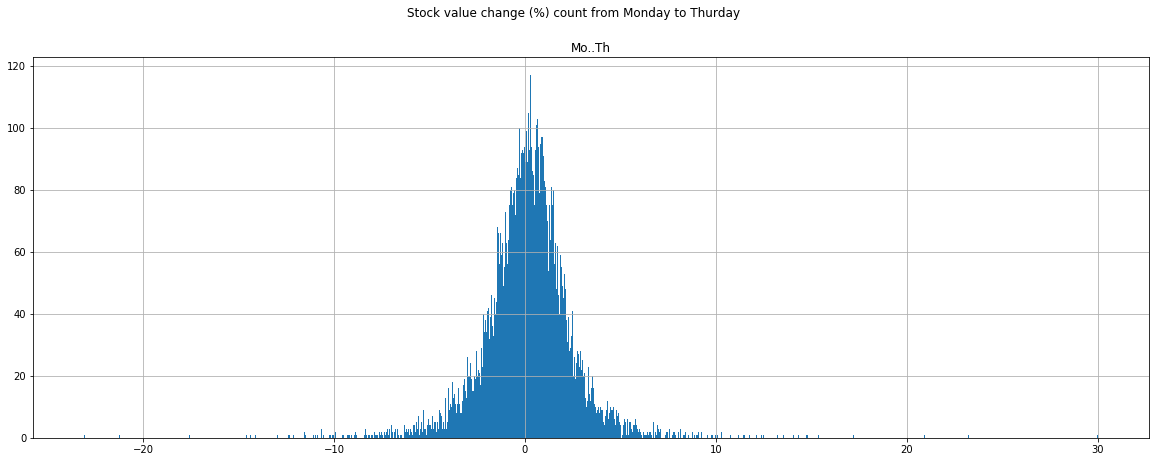

In [58]:
# Check values distribution
hist = dataout1.hist(bins=1000, figsize=(20,7), column=delta1)
plt.suptitle("Stock value change (%) count from Thurday to Monday")
hist = dataout1.hist(bins=1000, figsize=(20,7), column=delta2)
plt.suptitle("Stock value change (%) count from Monday to Thurday")